### 使用sklearn中的GMM模型

Text(0.5, 1.0, 'The result of K-means')

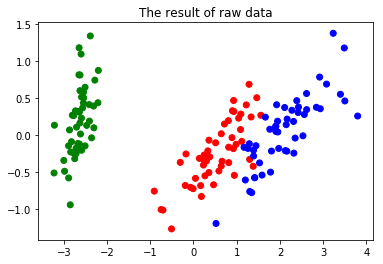

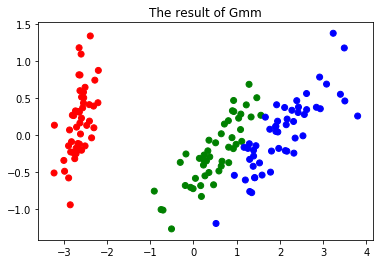

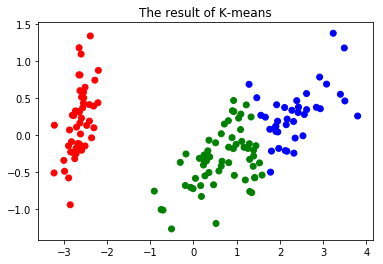

In [1]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA   #导入需要用到的方法
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

X,y=load_iris().data,load_iris().target
X=PCA(n_components=2).fit_transform(X)  #将元数据集的X降维至2维，方便可视化
model=GaussianMixture(n_components=3)   #初始化模型，聚为三类
model.fit(X)             #拟合模型
gmm_pre=model.predict(X)   #使用模型预测

k_means=KMeans(n_clusters=3).fit(X)
k_means_pre=k_means.predict(X)

color_dict={0:'green',1:'red',2:'blue'}
colors=[color_dict[i] for i in y]      #将真实的y进行可视化

plt.figure()
plt.scatter(x=X[:,0],y=X[:,1],color=colors)
plt.title('The result of raw data')


colors=[color_dict[i] for i in gmm_pre]      #将GMM预测结果可视化
plt.figure()
plt.scatter(x=X[:,0],y=X[:,1],color=colors)
plt.title('The result of Gmm')


colors=[color_dict[i] for i in k_means_pre]      #将K-means预测结果可视化
plt.figure()
plt.scatter(x=X[:,0],y=X[:,1],color=colors)
plt.title('The result of K-means')

### Numpy实现GMM模型

In [7]:
import numpy as np
np.random.seed(302100)
class GMM:
    def __init__(self,n_components):
        self.K=n_components                     #初始化k个高斯分布
        self.weights=np.ones(n_components)/n_components  #初始化k个高斯分布的权重
        
    def Gaussian(self,x,mean,cov):
        """
        这里自定义高斯分布的概率密度函数
        x:输入数据
        mean:均值数组
        cov:协方差矩阵
        return：数据x的概率
        """
        n=cov.shape[0]
        if np.linalg.det(cov)==0:   #如果协方差矩阵不可逆，将其加上一个非常小的单位阵使其可逆
            cov=cov+np.eye(n)*0.0001
        cov_det=np.linalg.det(cov)
        cov_inv=np.linalg.inv(cov)
        xdiff=x-mean
        prob=1/(np.power((2*np.pi),n/2)*(np.power(np.abs(cov_det),0.5)))*\
             np.exp(-0.5*xdiff.T.dot(cov_inv).dot(xdiff))
        return prob
    
    
    def fit(self,X):
        '''
        X：输入为p行q列的数据，p条数据，q个feature
        self.weights，一行，k列，代表第k个高斯分布的"占比"
        self.means，为均值向量，K个分类，所以为K行，q列的向量
        self.covars，为协方差矩阵，K个分类，q个feature，所以为K个协方差矩阵，每个协方差矩阵的shape=(q,q)
        oldloglikehood，上一步的的似然值
        loglikehood，新的似然值
        gammas，p行k列，代表第p条数据属于第k类高斯分布的概率
        
        '''
        self.Data=X
        p,q=self.Data.shape   #原始数据的size
        self.means=np.random.rand(self.K,q)   #初始化k个分布的均值向量
        self.covars=[]       #初始化协方差矩阵
        for i in range(self.K):
            cov=np.random.rand(q,q)
            self.covars.append(cov)
            
        loglikelyhood=0
        oldloglikelyhood=1
        
        # gamma表示第n个样本属于第k个混合高斯的概率     
        gammas = np.array([list(np.zeros(self.K)) for i in range(p)])
        
        while np.abs(loglikelyhood-oldloglikelyhood) > 0.00000001:
            oldloglikelyhood = loglikelyhood
            # E-step
            for i in range(p):  #迭代每一条数据
                respons = [self.weights[k] * \
                           self.Gaussian(self.Data[i], 
                                         self.means[k], self.covars[k]) for k in range(self.K)]
                respons = np.array(respons)    #respons，当前数据对第K个分布的响应
                sum_respons = np.sum(respons)   #当前数据的总响应
                gammas[i] = respons/sum_respons  #更新第i条数据对每个分布的响应占比
            # M-step
            for i in range(self.K):   #迭代K个分分类
                nk = np.sum([gammas[j][i] for j in range(p)])  #nk表示N个样本中有'多少'属于第k个高斯
                self.weights[i] = 1.0 * nk / p    # 更新每个高斯分布的概率
                self.means[i] = (1.0/nk) * np.sum([gammas[j][i] * self.Data[j] 
                                                   for j in range(p)], axis=0)  # 更新高斯分布的均值
                xdiffs = self.Data - self.means[i]
                # 更新高斯分布的协方差矩阵
                self.covars[i] = (1.0/nk)*np.sum([gammas[j][i]*xdiffs[j].reshape((q,1)).dot(xdiffs[j].reshape((1,q))) for j in range(p)],axis=0)
            loglikelyhood = []
            for i in range(p):
                tmp = [np.sum(self.weights[k]*self.Gaussian(self.Data[i],self.means[k],self.covars[k])) for k in range(self.K)]
                tmp = np.log(np.array(tmp))
                loglikelyhood.append(list(tmp))
            loglikelyhood = np.sum(loglikelyhood)
        for i in range(p):
            gammas[i] = gammas[i]/np.sum(gammas[i])
        self.posibility = gammas
        self.prediction = [np.argmax(gammas[i]) for i in range(p)]
        self.__means=self.means
        self.__covars=self.covars
        print(loglikelyhood)
    def transform(self,X):
        p,q=X.shape
        gammas = np.array([list(np.zeros(self.K)) for i in range(p)])
        for i in range(p):
            respons = [self.weights[k] * \
                           self.Gaussian(self.Data[i], self.means[k], self.covars[k])
                                                    for k in range(self.K)]
            respons = np.array(respons)
            sum_respons = np.sum(respons)
            gammas[i] = respons/sum_respons  #更新respons
        res=[np.argmax(gammas[i]) for i in range(p)]
        return res
        
    def predict_prob(self,X):
        p,q=X.shape
        gammas = np.array([list(np.zeros(self.K)) for i in range(p)])
        for i in range(p):
            respons = [self.weights[k] * \
                           self.Gaussian(self.Data[i], self.means[k], self.covars[k])
                                                    for k in range(self.K)]
            respons = np.array(respons)
            sum_respons = np.sum(respons)
            gammas[i] = respons/sum_respons  #更新respons
        return gammas

-32824.607760639905


Text(0.5, 1.0, 'The result of the handwritten GMM')

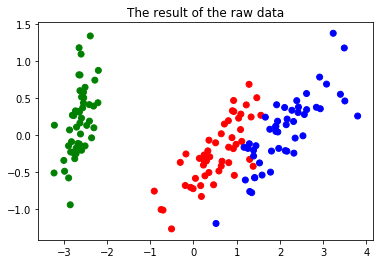

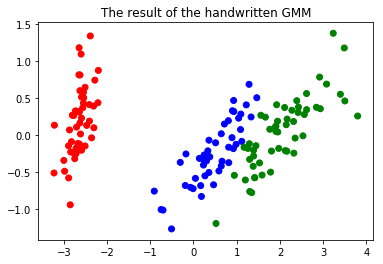

In [8]:
model=GMM(n_components=3)
model.fit(X)
pre=model.prediction

color_dict={0:'green',1:'red',2:'blue'}
colors=[color_dict[i] for i in y]      #将真实的y进行可视化
plt.figure()
plt.scatter(x=X[:,0],y=X[:,1],color=colors)
plt.title('The result of the raw data')

colors=[color_dict[i] for i in pre]      #将预测结果可视化
plt.figure()
plt.scatter(x=X[:,0],y=X[:,1],color=colors)
plt.title('The result of the handwritten GMM')